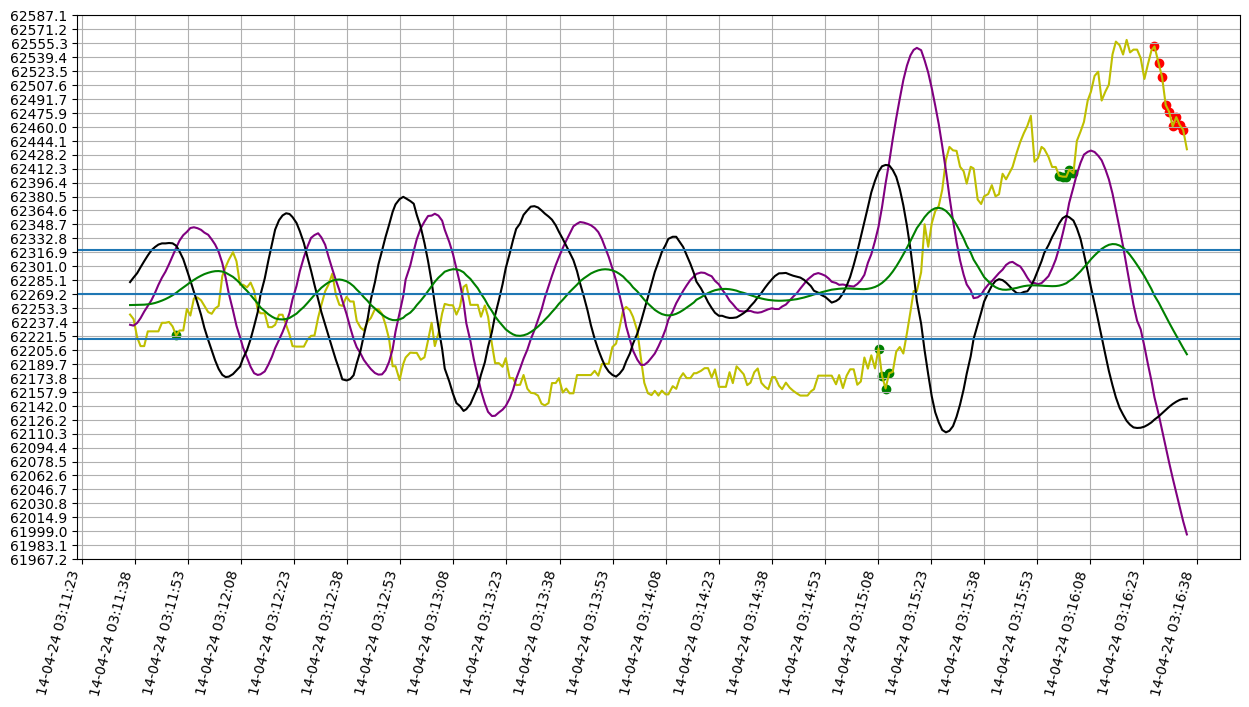

In [31]:
import pandas as pd
import os
import numpy as np
from datetime import datetime
import sympy as sp
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from binance import Client
from time import sleep
from IPython.display import clear_output

client = Client()

smooth_interval = 30
smooth_exp = 3
rango = 0
std_mult = 150
pdi_mult = 20
sdi_mult = 150
z_aprox = 0.05
pmax_idx = 0
pmin_idx = 0

while True:
    clear_output(wait=True)

    recent_data = pd.read_csv('../../csvs/streaming/BTCUSDT.csv')
    recent_data.columns = ['Tiempo','Simbolo','Open']
    recent_data = recent_data.loc[:,['Tiempo','Open']]
    recent_data['Tiempo'] = recent_data.Tiempo.astype('datetime64')
    recent_data = recent_data.set_index('Tiempo')
    recent_data['Open'] = recent_data.Open.astype(float)
    recent_data = recent_data.reset_index()

    ##################################################
    # Interpolación (suavizado)  del Precio (OPEN) con SciPy y obtención de derivadas con su respectiva interpolación.
    ##################################################
    recent_data['Interpolacion'] = sc.signal.savgol_filter(recent_data.Open,smooth_interval,3)
    recent_data['Primer_Derivada'] = recent_data.Interpolacion.diff()/(recent_data.Tiempo.diff()/np.timedelta64(1, 's'))
    recent_data['PD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Primer_Derivada,smooth_interval,3)
    recent_data['Segunda_Derivada'] = recent_data.PD_Interpolacion.diff()/(recent_data.Tiempo.diff()/np.timedelta64(1, 's'))
    recent_data['SD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Segunda_Derivada,smooth_interval,3)
    recent_data['Tercer_Derivada'] = recent_data.SD_Interpolacion.diff()/(recent_data.Tiempo.diff()/np.timedelta64(1, 's'))
    recent_data['TD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Tercer_Derivada,smooth_interval,3)
    recent_data['Mpd']=recent_data['PD_Interpolacion'].rolling(window=13).mean()
    # recent_data['Msd']=recent_data['SD_Interpolacion'].rolling(window=30).mean()

    try:
        initial_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[-60*5:-60*5 + 1].item()),'%Y-%m-%d %H:%M:%S.%f')].index.item() + rango
    except:
        initial_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[-60*5:-60*5 + 1].item()),'%Y-%m-%d %H:%M:%S')].index.item() + rango
    try:
        final_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[-1:].item()),'%Y-%m-%d %H:%M:%S.%f')].index.item() - rango
    except:
        final_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[-1:].item()),'%Y-%m-%d %H:%M:%S')].index.item() - rango

    lista_min_max = recent_data[initial_date_index:final_date_index][(recent_data[initial_date_index:final_date_index].TD_Interpolacion >= -z_aprox) & (recent_data[initial_date_index:final_date_index].TD_Interpolacion <= z_aprox)]
    indices_min_max = lista_min_max.index.tolist()

    max_points_idx = []
    min_points_idx = []
    pmin = 0
    pmax = 0

    for PMSD in indices_min_max:
        if (recent_data.SD_Interpolacion[PMSD:PMSD+1].item() > 0) & (recent_data.PD_Interpolacion[PMSD:PMSD+1].item() > 0) & (recent_data.Mpd[PMSD:PMSD+1].item()*8 > 0):# -abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
            if (abs(recent_data.SD_Interpolacion[PMSD]*10) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD]*pdi_mult) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
                pmax = recent_data.SD_Interpolacion[PMSD]
            for i in range(rango+1):
                if (i > PMSD) or (PMSD+i >= indices_min_max[-1:][0]):
                    break
                elif ((recent_data.SD_Interpolacion[PMSD-i] > pmax)) & ((abs(recent_data.SD_Interpolacion[PMSD-i]*sdi_mult)) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD-i]*pdi_mult) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
                    pmax_idx = PMSD-i
                elif ((recent_data.SD_Interpolacion[PMSD+i] > pmax)) & ((abs(recent_data.SD_Interpolacion[PMSD+i]*sdi_mult)) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD+i]*pdi_mult) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
                    pmax_idx = PMSD+i
                if pmax_idx == 0:
                    pass
                else:
                    max_points_idx.append(pmax_idx)
        elif (recent_data.SD_Interpolacion[PMSD:PMSD+1].item() < 0) & (recent_data.PD_Interpolacion[PMSD:PMSD+1].item() < 0) & (recent_data.Mpd[PMSD:PMSD+1].item()*8 < 0):# abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
            if (abs(recent_data.SD_Interpolacion[PMSD]*10) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD]*pdi_mult) < -abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
                pmin = recent_data.SD_Interpolacion[PMSD]
            for i in range(rango+1):
                if (i > PMSD) or (PMSD+i >= indices_min_max[-1:][0]):
                    break
                elif ((recent_data.SD_Interpolacion[PMSD-i] < pmin)) & (abs(recent_data.SD_Interpolacion[PMSD-i]*sdi_mult) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD-i]*pdi_mult) < -abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
                    pmin_idx = PMSD-i
                elif ((recent_data.SD_Interpolacion[PMSD+i] < pmin)) & (abs(recent_data.SD_Interpolacion[PMSD+i]*sdi_mult) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD+i]*pdi_mult) < -abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
                    pmin_idx = PMSD+i
                if pmin_idx == 0:
                    pass
                else:
                    min_points_idx.append(pmin_idx)
    max_points_idx = list(set(max_points_idx))
    min_points_idx = list(set(min_points_idx))
    max_points_idx.sort()
    min_points_idx.sort()

    mp = recent_data.Open[initial_date_index:final_date_index].mean()
    plt.figure(figsize=(15,8))
    plt.plot(recent_data.Tiempo[initial_date_index - rango:final_date_index + rango],recent_data.Open[initial_date_index - rango:final_date_index + rango].multiply(1),color='y')
    plt.plot(recent_data.Tiempo[initial_date_index:final_date_index],recent_data.PD_Interpolacion[initial_date_index:final_date_index].multiply(20)+mp,'purple')
    plt.plot(recent_data.Tiempo[initial_date_index:final_date_index],recent_data.SD_Interpolacion[initial_date_index:final_date_index].multiply(150)+mp,color='k')
    # plt.plot(recent_data.Tiempo[initial_date_index:final_date_index],recent_data.TD_Interpolacion[initial_date_index:final_date_index].multiply(300)+mp,color='y')
    plt.plot(recent_data.Tiempo[initial_date_index:final_date_index],recent_data.Mpd[initial_date_index:final_date_index].multiply(8)+mp,color='g')
    # plt.plot(recent_data.Tiempo[initial_date_index:final_date_index],recent_data.Msd[initial_date_index:final_date_index].multiply(500000)+mp,color='b')

    plt.scatter(recent_data.Tiempo.iloc[max_points_idx],recent_data.Open.iloc[max_points_idx],color='g')
    plt.scatter(recent_data.Tiempo.iloc[min_points_idx],recent_data.Open.iloc[min_points_idx],color='r')
    plt.grid(visible=True)

    # Set minor tick locations.
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y %H:%M:%S'))
    plt.gca().xaxis.set_major_locator(mdates.SecondLocator(interval=15))
    plt.gca().yaxis.set_major_locator(ticker.LinearLocator(40))
    plt.gcf().autofmt_xdate()

    # Set grid to use minor tick locations. 
    plt.grid(which = 'minor')
    plt.xticks(rotation=75)
    plt.axhline(mp)
    plt.axhline(np.std(recent_data.SD_Interpolacion)*std_mult + mp)
    plt.axhline(mp - np.std(recent_data.SD_Interpolacion)*std_mult)
    # plt.axvline(datetime.strptime('2024-04-04 09:59:00','%Y-%m-%d %H:%M:%S'))
    plt.show()
    # sleep(15)

In [ ]:
max_points_idx

NameError: name 'max_points_idx' is not defined